In [7]:
import climpy.utils.mie_utils as mie
import climpy.utils.aeronet_utils as aeronet
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import os
import scipy as sp

from climpy.utils.ncar_obs_utils import get_probed_size_distribution_in_riyadh
from climpy.utils.plotting_utils import JGR_page_width_inches, save_figure
from climpy.utils.refractive_index_utils import get_dust_ri
from climpy.utils.stats_utils import get_cdf
import matplotlib.transforms as mtransforms

__author__ = 'Sergey Osipov <Serega.Osipov@gmail.com>'

"""
https://github.com/SeregaOsipov/ClimPy/wiki/Aerosols-infographic

This is the modified version of aerosols_optical_properties_size_diags.py
Here, I use the airborne dust size distribution to access their contribution to aerosols optical properties and eventually to radiative forcing

Definitions from literature:
According to Ryder et al. (2019), the fine mode represents dust particles with D≤2µm, the coarse mode those with diameters between 2 and 20µm, and the giant mode particles with D≥20µm. A recent study (Claire Ryder, personal communication, 2021) suggests that the above modes can be further discretized into four categories, namely, fine (D<2.5µm), coarse (2.5–10µm), super-coarse (10–62.5µm), and giant (D>62.5µm).
"""

'\nhttps://github.com/SeregaOsipov/ClimPy/wiki/Aerosols-infographic\n\nThis is the modified version of aerosols_optical_properties_size_diags.py\nHere, I use the airborne dust size distribution to access their contribution to aerosols optical properties and eventually to radiative forcing\n\nDefinitions from literature:\nAccording to Ryder et al. (2019), the fine mode represents dust particles with D≤2µm, the coarse mode those with diameters between 2 and 20µm, and the giant mode particles with D≥20µm. A recent study (Claire Ryder, personal communication, 2021) suggests that the above modes can be further discretized into four categories, namely, fine (D<2.5µm), coarse (2.5–10µm), super-coarse (10–62.5µm), and giant (D>62.5µm).\n'

In [3]:
date = dt.datetime(2007, 4, 9)
sd_profile_df, column_sd_df, sd_columns, sd_diam_stag, sd_diam_rho = get_probed_size_distribution_in_riyadh(date)

r_orig_rho = column_sd_df.index / 2
r_mie_rho = np.logspace(-1, 2, 100)
r_data = np.unique(np.concatenate((r_mie_rho, r_orig_rho)))
ind = np.logical_and(r_data>=r_orig_rho.min(), r_data<=r_orig_rho.max())
r_data = r_data[ind]

# upsample
f = sp.interpolate.interp1d(r_orig_rho, column_sd_df)
dNdlogD = f(r_data)
dVdlogD = 4/3 * np.pi * r_data**3 * dNdlogD

TODO:FIND OUT FSSP & PCASP exact BINS


In [4]:
# get dust RI for Saudi
ri_vo = get_dust_ri()
wl_index_sw = 0  # wls are 0.52,  0.95, 10.
wl_index_lw = 2

In [5]:
# Compute Mie extinction coefficients
mie_vo = mie.get_mie_efficiencies(ri_vo['ri'], r_data, ri_vo['wl'])

cross_section_area_transform = 3/4 * r_data**-1
od = np.trapz(mie_vo['qext'] * dVdlogD * cross_section_area_transform, np.log(r_data), axis=1)

# compute the CDFs for volume/mass and AOD
volume_cdf = get_cdf(dVdlogD, np.log(r_data))
area_cdf = get_cdf(dVdlogD * cross_section_area_transform, np.log(r_data))
aod_cdf_sw = get_cdf(mie_vo['qext'][wl_index_sw] * dVdlogD * cross_section_area_transform, np.log(r_data))
aod_cdf_lw = get_cdf(mie_vo['qext'][wl_index_lw] * dVdlogD * cross_section_area_transform, np.log(r_data))

# radius setup
x_coord = r_data
x_coord_label = 'Radius'
x_coord_vline = 3
# diameter setup
# x_coord = 2*r_data
# x_coord_label = 'Diameter'
#x_coord_vline = 3*2

Wavelength 0 out of 3
Wavelength 1 out of 3
Wavelength 2 out of 3


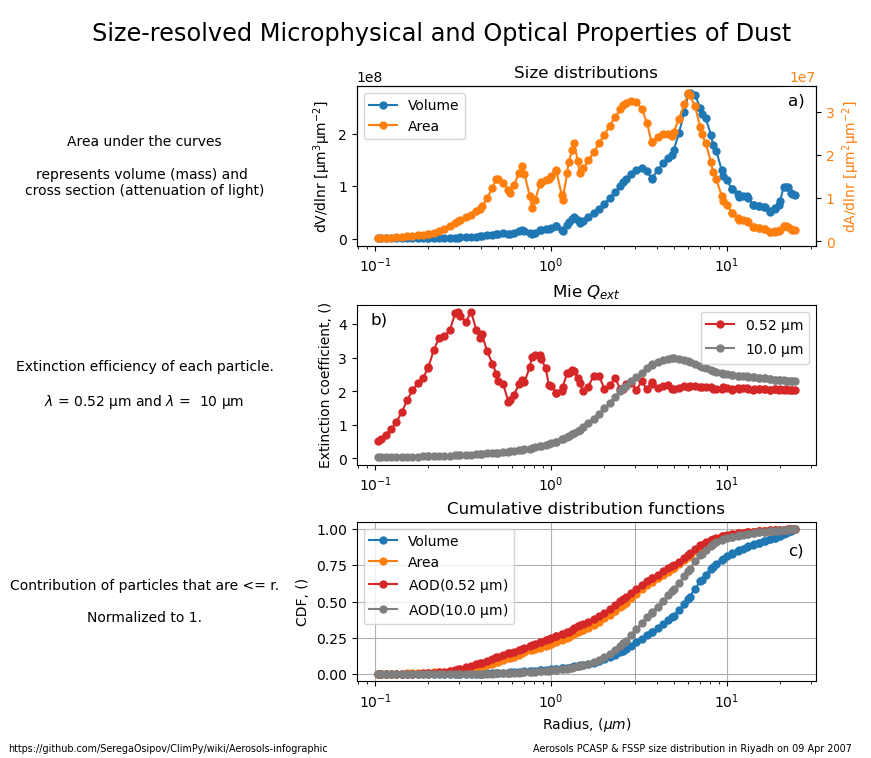

In [18]:
# DO THE PLOTTING
fig = plt.figure(constrained_layout=True, figsize=(JGR_page_width_inches() * 1.15, JGR_page_width_inches()))
# fig = plt.figure(figsize=(get_JGR_full_page_width_inches()*1., get_JGR_full_page_width_inches()))
gs = fig.add_gridspec(ncols=2, nrows=4, width_ratios=[1, 3], height_ratios=[3, 10, 10, 10])

# HEADER
ax_text = fig.add_subplot(gs[0, :])
ax_text.annotate(r'Size-resolved Microphysical and Optical Properties of Dust', (0.5, 0.5),
                 fontsize='xx-large', xycoords='axes fraction', va='center', ha='center')
ax_text.axis('off')


ax_text = fig.add_subplot(gs[1, 0])
ax_text.annotate('Area under the curves\n\nrepresents volume (mass) and \ncross section (attenuation of light)',
                 (0.5, 0.5), xycoords='axes fraction', va='center', ha='center')
ax_text.axis('off')

ax_text = fig.add_subplot(gs[2, 0])
ax_text.annotate('Extinction efficiency of each particle.\n\n$\lambda$ = {:3.2f} $\mathrm{{\mu m}}$ and $\lambda$ = {:3.0f} $\mathrm{{\mu m}}$'.format(ri_vo['wl'][wl_index_sw], ri_vo['wl'][wl_index_lw]), (0.5, 0.5),
                 xycoords='axes fraction', va='center', ha='center')
ax_text.axis('off')

ax_text = fig.add_subplot(gs[3, 0])
ax_text.annotate('Contribution of particles that are <= r.\n\nNormalized to 1.', (0.5, 0.5),
                 xycoords='axes fraction', va='center', ha='center')
ax_text.axis('off')

# the plots itself
ax = fig.add_subplot(gs[1, 1])
plt.sca(ax)
plt.plot(x_coord, dVdlogD, '-o', markersize=5, label='Volume')
plt.xscale('log')
# plt.xlabel('{}, ($\mu m$)'.format(x_coord_label))
plt.ylabel('dV/dlnr [$\mathrm{\mu m^3 \mu m^{-2}}$]')
plt.title('Size distributions')
# plt.legend(loc='upper left')

trans = mtransforms.ScaledTranslation(-20/72, -5/72, fig.dpi_scale_trans)
ax.text(1.0, 1.0, 'a)', transform=ax.transAxes + trans, fontsize='large', verticalalignment='top', bbox=dict(facecolor='white', edgecolor='none'))


color = 'tab:orange'
ax2 = ax.twinx()
plt.sca(ax2)
plt.xscale('log')
plt.tick_params(axis='y', labelcolor=color)
plt.plot(x_coord, dVdlogD*3/4*r_data**-1, '-o', markersize=5, color=color, label='Area')
plt.ylabel('dA/dlnr [$\mathrm{\mu m^2 \mu m^{-2}}$]', color=color)
# plt.legend(loc='upper right')

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax2.legend(h1+h2, l1+l2, loc='upper left')

# ax = fig.add_subplot(gs[2, 1])
# plt.sca(ax)
# plt.plot(ri_vo['wl'], np.real(ri_vo['data']), '-o')
# plt.xlabel('Wavelength, ($\mu m$)')
# plt.ylabel('Re(refractive index)')
#
# color = 'tab:gray'
# ax2 = ax.twinx()
# ax2.tick_params(axis='y', labelcolor=color)
# plt.plot(ri_vo['wl'], np.imag(ri_vo['data']), '-o', color=color)
# plt.ylabel('Im(refractive index)', color=color)
# plt.title('Refractive index')

ax = fig.add_subplot(gs[2, 1])
plt.sca(ax)
plt.plot(x_coord, mie_vo['qext'][wl_index_sw], '-o', color='tab:red', markersize=5, label='{} $\mathrm{{\mu m}}$'.format(ri_vo['wl'][wl_index_sw]))  # x_coord is sample the same as 2*mie_vo['r_data']
plt.plot(x_coord, mie_vo['qext'][wl_index_lw], '-o', color='tab:gray', markersize=5, label='{} $\mathrm{{\mu m}}$'.format(ri_vo['wl'][wl_index_lw]))  # x_coord is sample the same as 2*mie_vo['r_data']
plt.legend()
plt.xscale('log')
# plt.xlabel('{}, ($\mu m$)'.format(x_coord_label))
plt.ylabel('Extinction coefficient, ()')
plt.title('Mie $Q_{ext}$')

trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
ax.text(0.0, 1.0, 'b)', transform=ax.transAxes + trans, fontsize='large', verticalalignment='top', bbox=dict(facecolor='white', edgecolor='none'))


ax = fig.add_subplot(gs[3, 1])
plt.sca(ax)
plt.grid()
plt.axvline(x=x_coord_vline, color='tab:gray', linewidth=0.5)
plt.plot(x_coord, volume_cdf/volume_cdf[-1], '-o', markersize=5, label='Volume')
plt.plot(x_coord, area_cdf/area_cdf[-1], '-o', markersize=5, label='Area')
plt.plot(x_coord, aod_cdf_sw/aod_cdf_sw[-1], '-o', color='tab:red', markersize=5, label='AOD({} $\mathrm{{\mu m}}$)'.format(ri_vo['wl'][wl_index_sw]))
plt.plot(x_coord, aod_cdf_lw/aod_cdf_lw[-1], '-o', color='tab:gray', markersize=5, label='AOD({} $\mathrm{{\mu m}}$)'.format(ri_vo['wl'][wl_index_lw]))
plt.xscale('log')
plt.xlabel('{}, ($\mu m$)'.format(x_coord_label))
plt.ylabel('CDF, ()')
plt.title('Cumulative distribution functions')  #  \n normalized to 1
plt.legend()

trans = mtransforms.ScaledTranslation(-20/72, -15/72, fig.dpi_scale_trans)
ax.text(1.0, 1.0, 'c)', transform=ax.transAxes + trans, fontsize='large', verticalalignment='top')#, bbox=dict(facecolor='white', edgecolor='none'))


# text at the bottom
panel_annotation_lr = 'Aerosols PCASP & FSSP size distribution in Riyadh on {}'.format(date.strftime('%d %b %Y'))
an = plt.annotate(panel_annotation_lr, (0.99, 0.0135), fontsize='x-small', xycoords='figure fraction', va='center', ha='right')
an.set_in_layout(True)
url = 'https://github.com/SeregaOsipov/ClimPy/wiki/Aerosols-infographic'
# have to create new axis because of the bug in constrained_layout
ax_b = plt.axes((0.01, 0.015, 0.5, 0.075), facecolor='w')
plt.annotate('{}'.format(url), (0.01, 0.0135), fontsize='x-small', xycoords='figure fraction', va='center', ha='left')
ax_b.axis('off')
# plt.tight_layout()

save_figure(os.path.expanduser('~') + '/Pictures/DustRadiativeForcing/', 'Dust size distribution and optical properties, {}'.format(x_coord_label), dpi=300)
save_figure(os.path.expanduser('~') + '/Pictures/DustRadiativeForcing/', 'Dust size distribution and optical properties, {}'.format(x_coord_label), file_ext='svg')

TODO:FIND OUT FSSP & PCASP exact BINS
TODO:FIND OUT FSSP & PCASP exact BINS


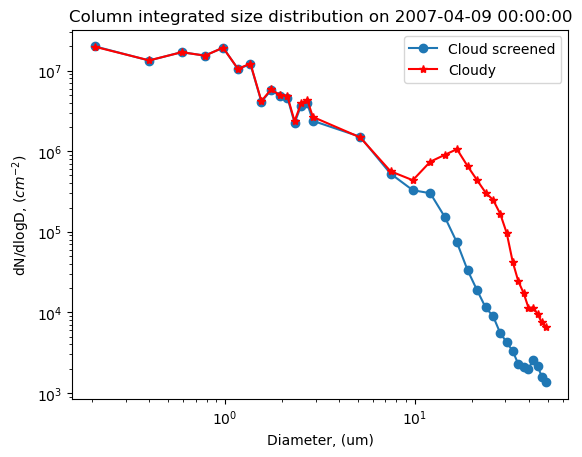

In [71]:
# Plot the original SD, cloud screened and not
date = dt.datetime(2007, 4, 9)
sd_profile_df, column_sd_df, sd_columns, sd_diam_stag, sd_diam_rho = get_probed_size_distribution_in_riyadh(date)
sd_profile_df_cloudy, column_sd_df_cloudy, sd_columns, sd_diam_stag, sd_diam_rho = get_probed_size_distribution_in_riyadh(
    date, do_cloud_screening=False)
plt.clf()
column_sd_df.plot(marker='o', label='Cloud screened')
column_sd_df_cloudy.plot(marker='*', color='r', label='Cloudy')
plt.legend()
plt.xlabel("Diameter, (um)")
plt.ylabel('dN/dlogD, ($cm^{-2}$)')
plt.title('Column integrated size distribution on {}'.format(date))
save_figure(os.path.expanduser('~') + '/Pictures/DustRadiativeForcing/', 'ncar size distribution', dpi=300)
save_figure(os.path.expanduser('~') + '/Pictures/DustRadiativeForcing/', 'ncar size distribution', dpi=300, file_ext='svg')

plt.xscale('log')
plt.yscale('log')
save_figure(os.path.expanduser('~') + '/Pictures/DustRadiativeForcing/', 'ncar size distribution log', dpi=300)
save_figure(os.path.expanduser('~') + '/Pictures/DustRadiativeForcing/', 'ncar size distribution log', dpi=300, file_ext='svg')

In [25]:

mie_vo = mie.get_mie_efficiencies(ri_vo['ri'], r_data, ri_vo['wl'])
# mie_vo = get_mie_efficiencies(ri_vo['ri'], r_data, ri_vo['wl'])

cross_section_area_transform = 3/4 * r_data**-1
od = np.trapz(mie_vo.qext * dVdlogD * cross_section_area_transform, np.log(mie_vo.radius), axis=1)

In [26]:
od

array([1.67938335e+08, 1.77542827e+08, 1.29582734e+08])